In [1]:
#follow the command to install any package:
#!pip install torch


### Install Packages

In [2]:
#Import the librarry

import numpy as np  # For mathematical computations and array operations
import torch  # For deep learning, tensor computations, and GPU acceleration
from torch.utils.data import Dataset, DataLoader, ConcatDataset  # For handling and loading datasets efficiently
import glob  # For file searching and pattern matching in directories to get the images
import matplotlib.pyplot as plt  # For data visualization and plotting graphs and see the model expriance in vizualize
from sklearn.metrics import confusion_matrix, accuracy_score  # For evaluating model performance, mainly Conf_Matrix
import random  # For generating random numbers and shuffling data
import cv2  # For image processing and computer vision tasks
import sys  # For system-specific parameters and functions, such as handling command-line arguments


### Reading the images:



##### Import the data from :https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?resource=download




In [3]:
tumor = []

#Matches .png, .jpeg, .jpg, .JPG, .JPEG, .PNG (case-insensitive).

    #[pPjJ] → Matches p, P, j, or J (for png, jpg, jpeg).

    #[nNpP]* → Matches optional n, N, or p, P (for png, jpeg).

    #[gG] → Ensures it ends with g or G.

path = './archive/brain_tumor_dataset/yes/*.[pPjJ][nNpP]*[gG]' 

for f in glob.iglob(path):
    img = cv2.imread(f) # Reading the each image from the path
    
    #Since the data has different dimension, we have to have conssistant dimensions.
    #Let's fix it 
    img = cv2.resize(img, (128,128)) # the dimension of the image set or resize  to 128x128pxl
   
    #Not essentiall but nice to have conventionally 
    b, g, r = cv2.split(img) # spliting the image in blue, green, and red Channals
    img = cv2.merge([r, g, b]) # Then Merge by red, green, blue (RGB) order
    
    tumor.append(img) # Append the img to tumor list 
    
print ("Tumor count:",len(tumor))


healthy=[]

for f in glob.iglob("./archive/brain_tumor_dataset/no/*.[pPjJ][nNpP]*[gG]"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

print ("Healthy count:", len(healthy))

Tumor count: 155
Healthy count: 98


In [4]:
#Check the size of the image
for i in tumor[1:5]:
    print("This are the sape of the image:", i.shape)
#128 by 128 dimension by 3 channals (RGB)

This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)


In [5]:
#Convert to array
healthy = np.array(healthy)
tumor = np.array(tumor)


In [6]:
print(tumor.shape)
print(healthy.shape)
# For example: For healthy we have 155 image, with 3 channals in dimension of 128 x128 pxl

(155, 128, 128, 3)
(98, 128, 128, 3)


In [7]:
ALL = np.concatenate((healthy, tumor))
print(ALL.shape) # the image joined and become 155 + 98 = 253.

(253, 128, 128, 3)


In [8]:
# Select three random image/number between 0 to 4 [among five indeces value] using np.random.choice.
np.random.choice(5, 3, replace = False) #replace Helps that are not duplicate the same number at the same time. 

array([3, 2, 0])

### Visualize the MRI image

AxesImage(shape=(128, 128, 3))


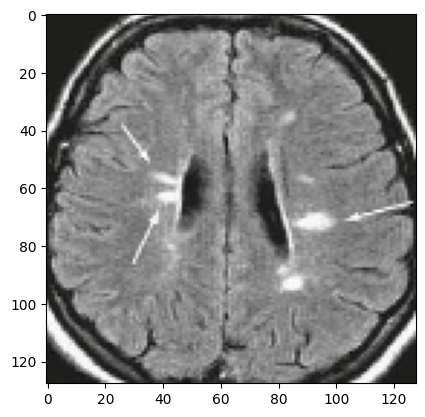

In [9]:
print(plt.imshow(healthy[0])) # Healthy Brain Image

AxesImage(shape=(128, 128, 3))


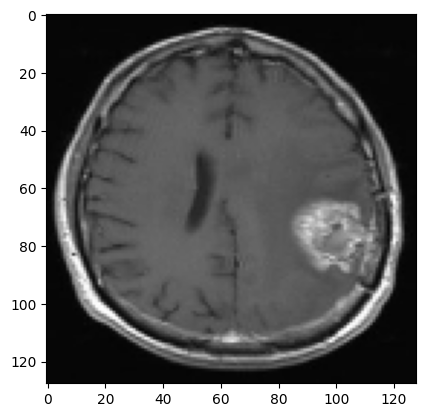

In [10]:
print(plt.imshow(tumor[0])) # Healthy Brain Image

In [11]:
# Let's Create a function that can pull 5 random image from the image data and shows in order with two classifications 

def plot_random(healthy, tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace = False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace = False)]

    plt.figure(figsize = (16,9))
    for i in range(num):
        plt.subplot(1, num, i+1) # i+1 because we can not plot indeces 0, so we can pull the first 1 by adding 1 in i.
        plt.title ("healthy")
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize = (16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title ("Tumor")
        plt.imshow(tumor_imgs[i])
   
   

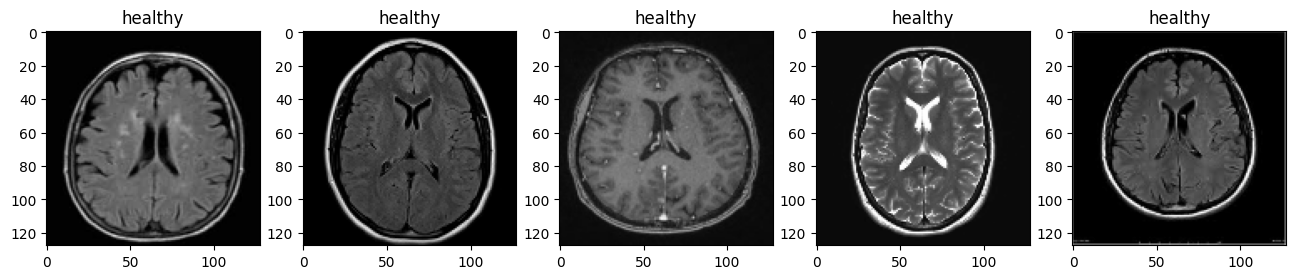

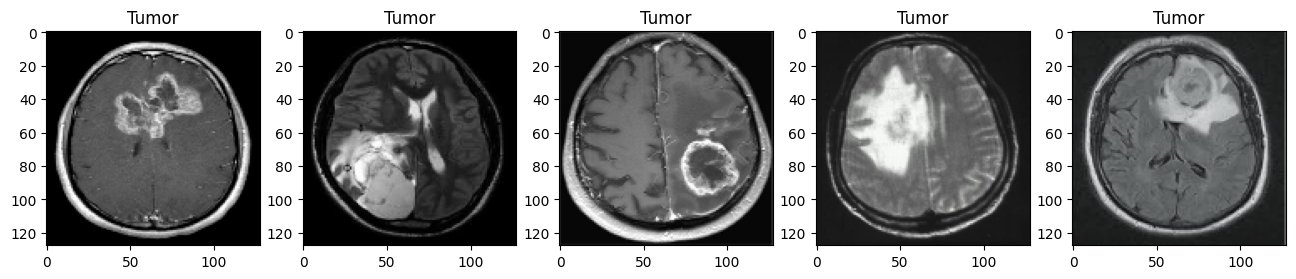

In [12]:
plot_random(healthy, tumor, num = 5)

In [13]:
# Let's Create torch data set from the image

#### Torch DataSets

In [14]:
# We have to overide or simply creating new module/class some class in pytorch! To do this Let's see an example:

class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Any assigned dataset from this class can override add as concatenate two data set. we can also modify __getitem__ by replacing 
# "raise NotImplementedError" with some function like self.x[index], you might get some result. The point is we have to ovveride the class, or create a new 
# class from the above dataset(). watch: https://www.youtube.com/watch?v=uvvuDjzjKio&list=PL5foUFuneQnratPPuucpVxWl4RlqueP1u&index=7 



##### Any assigned dataset from this class can override add as concatenate two data set. we can also modify __getitem__ by replacing  "raise NotImplementedError" with some function like self.x[index], you might get some result. The point is we have to ovveride the class, or create a new  class from the above dataset(). 

##### With bing that said, let's Create a Customized Pytorch Class!

### Pythorch Customized Class!

In [15]:
#This calss contain everything and access it and implemented automatically, insted we can finish everything outside and pass the data to the class at the end
class MRI(Dataset):
    
    def __init__(self):
        
        tumor = []
        path = './archive/brain_tumor_dataset/yes/*.[pPjJ][nNpP]*[gG]' 

        for f in glob.iglob(path):
            img = cv2.imread(f) # Reading the each image from the path
            
            #Since the data has different dimension, we have to have conssistant dimensions.
            #Let's fix it 
            img = cv2.resize(img, (128,128)) # the dimension of the image set or resize  to 128x128pxl
           
            #Not essentiall but nice to have conventionally 
            b, g, r = cv2.split(img) # spliting the image in blue, green, and red Channals
            img = cv2.merge([r, g, b]) # Then Merge by red, green, blue (RGB) order
            
            tumor.append(img) # Append the img to tumor list 
            
        #print ("Tumor count:",len(tumor))
        
        
        healthy=[]
        
        for f in glob.iglob("./archive/brain_tumor_dataset/no/*.[pPjJ][nNpP]*[gG]"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            healthy.append(img)
        
        #print ("Healthy count:", len(healthy))

        #Our Image is here in array with type of float
        healthy = np.array(healthy, dtype = np.float32)
        tumor = np.array(tumor, dtype = np.float32)


        #Our labels (0,1) is here in array with type of float.
        tumor_labels = np.ones(tumor.shape[0], dtype = np.float32) # Make it np.ones (1's) each image in tumor
        healthy_labels = np.zeros(healthy.shape[0], dtype = np.float32) # Make it np.zeros (0's) each image in tumor, it's fine to have float

        # We are going to self function for concatenate.
        # axis helps to add the first tumor on top of healthy, which make it (155, 128, 128) + (98, 128, 128) = (243, 128, 128)
        self.images = np.concatenate((tumor, healthy), axis = 0) 
        self.labels = np.concatenate((tumor_labels, healthy_labels), axis = 0)

    
    def __len__ (self):
        return self.images.shape[0] # we are creating like global len() func by returning only self.image.shape[0], which is the first element of shape tuple.
   
    
    def __getitem__(self, index):
        sample = {"images":self.images[index], "label": self.labels[index]} #Creating dict assists to pass two argument when index lodded to the class.
        return sample

    def normalize(self):
        self.images = self.images/255.0


In [16]:
mri = MRI()


In [17]:
#Normalize everything between 0 and 1
#mri.normalize()

### Data Loader

#### Let's see before a dataloder how it's look like!
* Data loder make it fast and easily suffile and dividded in mini-batch cause we have to. Nural network also need mini-batch.


In [18]:
#Let's Normalize!
mri.normalize()

image shape: (128, 128, 3)


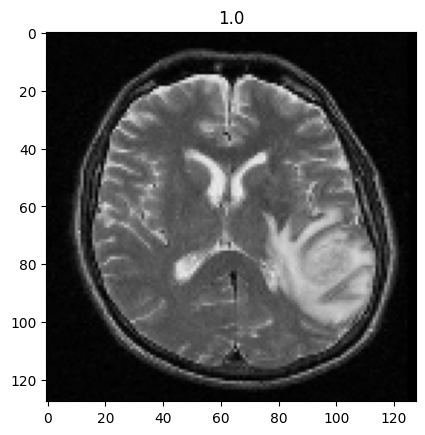

SystemExit: 

/opt/anaconda3/envs/MRI/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
index = list(range(len(mri))) # Creating a list for the images
random.shuffle(index) # Sufflling the index to corosponding images
for i in index:
    sample = mri[i]
    # print(sample)
    img = sample["images"]
    label = sample["label"]
    print("image shape:", img.shape)
    #img = img.reshape(img.shape[1], img.shape[2], img.shape[0]) # No need!, But incase - reshaping the image because the above dimension is channals , Hieght, width
    #print("image after:", img.shape)
    plt.title(label)# 1 - Tumor, 0- Normal
    plt.imshow(img)
    plt.show()

    sys.exit() # Help us exit from the loop insted of terminating the cell!

####  Now, Let's come to easy way, which is a python has a command help us to itrate. I perfer to use this and it's really important, which is turn in to mini-batchs in this case I would say 10 mini batchs. Our MRI data set canb be itrate since we have dunder fun or a MRI class

In [ ]:
it = iter(mri)# itrating mri class and assigned by "itr"
print(it)
for i in range(10):# 10 mini batchs (dataset) itrable, which we can limit the number of image too.
    sample = next(it)
    img = sample["images"]
    label = sample["label"]
    plt.title(label)# 1 - Tumor, 0- Normal
    plt.imshow(img)
    plt.show()
    sys.exit()


### Data-loader fun from pythorch library

In [ ]:
# dataloder from pytorch and put mri class, 
# batch_size - indicate that how many image will load to the itrations. This time 10 image lodded
dataloader = DataLoader(mri, batch_size = 10, shuffle = True)

In [ ]:
for sample in dataloader:
    img = sample["images"].squeeze() # squeeze() will help us to remove the added dimension from the image 
    # torch.Size([1, 128, 128, 3]), - 1, shows the number of image with the dimensions.  
    print("image after:", img.shape)
    #plt.imshow(img)
    #plt.show()
    sys.exit()

### Building CNN - Convolutional Network



In [20]:
import torch.nn as nn 
import torch.nn.functional as F 

#let's create a class for CNN, pythorch needed a sub-class, which is module in this case.
# 

class CNN(nn.Module):
    def __init__(self): # It's a constructor, which is ablity to turn therm paramater objects.
        super(CNN, self).__init__() # Keeping everything what is in init above, and Super pass the name of the class and pointer(self), sub class 
        
        
        self.cnn_model = nn.Sequential( #nn can help you to choose 2d convo;utional dimension image paramater
            
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5 ),    # How many channals do we have for this first CNN layers, we have 3 channals, then out channals, which means how many CNN filters do we need, I chose to go with 6 filters/kernals. But, what size for filters. Kernal_size = 5, I chose 5 by 5.
        nn.Tanh(), # It's just mathimatical opreation (tangenth) implemented on 6 channals/filters fpr first CNN layers
        nn.AvgPool2d(kernel_size = 2, stride= 5), #This is sechond average linear layer. Pulling, average pooling in 2 dimensional (128,128), which is averageing the windows and getting out to small number of aggregated layers.  Stride is the higher stride the data willl crushed in dimensionally way.
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 5 ), # Learn more future map by combining the egde and learn about if it's circle, rectangle what is looks the image. Filters go up to 16!
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 2, stride= 5)) # This is third average linear layer

        
        # Fully Connected Modeling in a squence.
        self.fc_model = nn.Sequential( 
        nn.Linear(in_features= 256, out_features=120), # we sort from 128x128 with three channals to 256 values, which is arbitrary numbers. How does it happen? read more!
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))  #the output looks like linear lines


    def forward(delf, x): # x is image that passes to this fun.
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) # it's flatted 2d array. look the Supplment_documentation.ipynb
        x = self.fc_model(x)
        x = F.sigmoid(x) # pulling sigmoid because it's a binary classification.

        return x

   




#### The Flatten Opreation

nn.Linear(in_futures = 256, out_features=120)

- we sort from **128x128** with three channals to 256 values, which is arbitrary numbers. 

The logic Behind numebrs:

nn.Conv2d(in_channels=3, out_channels=6, kernel_size = 5 )

- This is a function recived the input data : kernal size(f), stride(s), n_in = dimension, which is 128, padding=0.
- The grand Formula : n_out = ((n_in + 2(p) - f)/s) + 1  
- **n_in 128, f = 5, s=1, p=0, filters = 6**
- Then based on the formula, number of output: ((128 + 2(p) - 5)/1)+1  = 124, which is the dimension 124x124 with 3 channals.

The first Average Pooling:

- nn.AvgPool2d(kernel_size = 2, stride= 5)
- n_out = ((n_in + 2(p) - f)/s) + 1
- we have kernal size(f) and stride(s), which are 2 and 5 respectively .
- n_out = ((124 + 2(0) - 2)/5) + 1 = 25

The sechond layer average pooling:

nn.AvgPool2d(**kernel_size = 2, stride= 5**))

nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 5 )

- n_out = ((n_in + 2(p) - f)/s) + 1
- we have kernal size(f) from nn.Conv and stride(s) from avgpool, which are 5 and 1 respectively . We have also n_in 25, p=0
- n_out = ((25 + 2(0) - 5)/1) + 1 = 21


The third average pooling:

nn.AvgPool2d(**kernel_size = 2, stride= 5**))

nn.Conv2d(in_channels=3, **out_channels=16**, kernel_size = 5 )

- n_out = ((n_in + 2(p) - f)/s) + 1
- we have kernal size(f) and stride(s) from avgpool, which are 2 and 15respectively . We have also n_in 25, p=0
- n_out = ((21 + 2(0) - 2)/4) + 1 = 4


- 4x4x16 = 256, which are **4 by 4** dimensions to **16 layer**, which can we get 256 individual element layer. This we are using in :
  
 nn.Linear(in_futures = 256, out_features=120)



In [21]:
model = CNN()

In [22]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [23]:
model.cnn_model # The first seaction  of the block

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [24]:
model.cnn_model[0] # first line of tee code

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [25]:
model.cnn_model[0].weight.shape # 6 filters, 3 channals, 5x5 dimensions. Note that, tehy sum up to one these channals then it's going to be converted 2d dimensions. that's why the out-put channals 6 channals.

torch.Size([6, 3, 5, 5])

In [26]:
model.cnn_model[0].weight[0].shape # three channals and 5x5 dimensions filters.
# torch.Size([3, 5, 5])

torch.Size([3, 5, 5])

#### Linear layer Model

In [27]:
 # Full connection model has 120x120 dimension with 256 layer.
model.fc_model[0].weight.shape

torch.Size([120, 256])

#### Understanding x.view (x.size(0),-1)

In [28]:
x = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [29]:
x = x.reshape((2,2,2,2)) #(32, 3, 128, 128) means that, 32 images, 3 channals, 128x128 dimensions
x 

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 10],
          [11, 12]],

         [[13, 14],
          [15, 16]]]])

In [30]:
x.size(0) # It's create 2 mini batch that contain two matrix at each.

2

In [31]:
x.view(-1) # It's falatten it and we will get the input value. but we don't need this. we want 32 images have to be flattedned. 

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [32]:
x.view(x.size(0), -1) # It's flattend in 2 dimensions separatly. 

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16]])

In [33]:
x.view(x.size(0), -1).shape 

torch.Size([2, 8])

#### Training and Evaluation in Pytorch

#### model.eval()

- A function undel model class, Keeps track of forward and backward and compute after every computation then evaluated the model how actually be trained the data.
- Activatin layer on and off then see how the model behave.
- To teset your model you use model.eval
  * Turnouf the dropout, cause it's only for training the data now we are in test
  * mini batch mean and SD not being used this time.
- Used particularly for inference **NOTHING to DO with gradients!!!**
- changes the forward() behaviour of the module it is called up on eg, it disables dropout and has batch norm use the entire population statistics. This is necessary for inference

#### model.train()

-Unlike model.eval, the droput will act by on and off the layers through out itrations.
- Brings drop out and batch norm to action (i.e., train mode). 
- Gradients are computed

#### Key Points:

- Numpy array can be used for ML algorithm, pytorch tensors are used mainly for deep learning, which is lead to have big matrix computation
- pytorch acept device compuattion hardware type (CPU and GPU)
- To use CPU : torch.tensor
-To use GPU : torch.cuda.tensor
* We can put as a condition for device selection.
*  * device will be 'cuda' if a GPU is available


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### When we use GPU and CPU?

CUDA or the device use GPU, (which is much faster in most cases). But, you have to make sure that ALL tensors you are using are CUDA Tensors, mixing is not possible here. Use CPU for both or GPU.


As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command. .cpu() returns a copy of this object in CPU memory.